In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
data_root_train = '/content/drive/MyDrive/2025_1_Colab/DeepLearning/Lib/midtest_data/train'
data_root_test = '/content/drive/MyDrive/2025_1_Colab/DeepLearning/Lib/midtest_data/test'

In [22]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))
    ])

train_set = torchvision.datasets.ImageFolder(root=data_root_train, transform=trans)
test_set = torchvision.datasets.ImageFolder(root=data_root_test, transform=trans)

In [23]:
print(f"Train 데이터 개수: {len(train_set)}") # Train 데이터 개수 확인
print(f"Test 데이터 개수: {len(test_set)}") # Test 데이터 개수 확인
classes = train_set.classes # classes로 결과값들도 확인
classes

Train 데이터 개수: 130
Test 데이터 개수: 30


['battery', 'pen', 'post_it']

In [24]:
batch_size = 32 # 32개의 배치사이즈로 미니배치

train_loader = DataLoader (
    train_set, batch_size=batch_size,
    shuffle = True
)

test_loader = DataLoader (
    test_set, batch_size=batch_size,
    shuffle = False
)

for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([32, 3, 32, 32])
Image label dimensions: torch.Size([32])


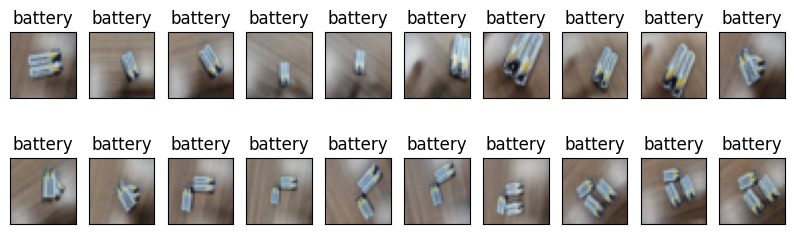

In [25]:
plt.figure(figsize=(10,3))
for i in range(20):
  ax = plt.subplot(2, 10, i+1)

  # image, label 취득
  image, label = train_set[i]

  # 이미지 출력
  plt.imshow(np.transpose(image,(1,2,0)))
  ax.set_title(f'{classes[label]}')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [26]:
class CNN1(nn.Module):
  def __init__(self):
    super(CNN1,self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # kernel = 필터 사이즈
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.l1 = nn.Linear(in_features=32*16*16, out_features=50)
    self.l2 = nn.Linear(in_features=50, out_features=10)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.layer1(x)

    x = x.view(x.size(0), -1)

    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    return x

In [27]:
torch.cuda.manual_seed(123)

model = CNN1()
model.to(device)
lr = 1e-3

# 손실 함수: 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

history = np.zeros((0, 5))

# tqdm 라이브러리 임포트
from tqdm.notebook import tqdm

num_epochs = 20

for epochs in range(num_epochs):
  train_acc, train_loss = 0, 0
  test_acc, test_loss = 0, 0
  n_train, n_test = 0, 0

  # 훈련 페이즈
  for inputs, labels in tqdm(train_loader):
    n_train += len(labels)

    # GPU 설정
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad() # Gradient 초기화

    outputs = model(inputs) # 순전파 계산

    loss = criterion(outputs, labels) # 손실값 계산

    loss.backward() # 역전파 계산

    optimizer.step() # 변수 업데이트

    predicted = outputs.max(axis=1)[1] # 실제 예측은 output중에서 가장 높은 값이 있는 위치

    train_loss += loss.item()
    train_acc += (predicted == labels).sum().item() # 예측과 실제값이 같은 것의 개수

  # 예측 페이즈
  for inputs_test, labels_test in test_loader:
    n_test += len(labels_test)

    # GPU 설정
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    outputs_test = model(inputs_test) # 순전파 계산

    loss_test = criterion(outputs_test, labels_test) # 손실값 계산

    predicted_test = outputs_test.max(axis=1)[1]

    test_loss += loss_test.item()
    test_acc += (predicted_test == labels_test).sum().item() # 손실 및 정확도 저장

  # 평가 결과 산출, 기록
  train_acc = train_acc / n_train # Train 정확도
  train_loss = train_loss / n_train # Train loss
  test_acc = test_acc / n_test # Test 정확도
  test_loss = test_loss / n_test # Test loss

  item = np.array([epochs + 1, train_loss, train_acc, test_loss, test_acc])
  history = np.vstack((history, item)) # Epoch 마다 손실 정확도 저장

  # Epoch 마다 손실과 정확도 표기
  print(f'Epoch [{epochs+1}/{num_epochs}, loss: {train_loss:.5f} acc: {train_acc:.2f} test_loss: {test_loss:.5f}, test_acc: {test_acc:.2f}]')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/20, loss: 0.06621 acc: 0.25 test_loss: 0.04097, test_acc: 0.33]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [2/20, loss: 0.04206 acc: 0.46 test_loss: 0.03337, test_acc: 0.50]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [3/20, loss: 0.03465 acc: 0.52 test_loss: 0.04028, test_acc: 0.33]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [4/20, loss: 0.03819 acc: 0.48 test_loss: 0.03273, test_acc: 0.37]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [5/20, loss: 0.03353 acc: 0.57 test_loss: 0.03188, test_acc: 0.40]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [6/20, loss: 0.03301 acc: 0.60 test_loss: 0.02767, test_acc: 0.63]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [7/20, loss: 0.02838 acc: 0.72 test_loss: 0.02674, test_acc: 0.70]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [8/20, loss: 0.02334 acc: 0.76 test_loss: 0.02764, test_acc: 0.63]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [9/20, loss: 0.02580 acc: 0.68 test_loss: 0.02536, test_acc: 0.70]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [10/20, loss: 0.02530 acc: 0.71 test_loss: 0.02378, test_acc: 0.77]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [11/20, loss: 0.02384 acc: 0.82 test_loss: 0.02261, test_acc: 0.73]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [12/20, loss: 0.01986 acc: 0.81 test_loss: 0.02105, test_acc: 0.83]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [13/20, loss: 0.02256 acc: 0.79 test_loss: 0.02057, test_acc: 0.87]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [14/20, loss: 0.02048 acc: 0.81 test_loss: 0.02315, test_acc: 0.70]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [15/20, loss: 0.02466 acc: 0.73 test_loss: 0.01870, test_acc: 0.80]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [16/20, loss: 0.01946 acc: 0.82 test_loss: 0.02254, test_acc: 0.63]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [17/20, loss: 0.01848 acc: 0.79 test_loss: 0.02065, test_acc: 0.73]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [18/20, loss: 0.01652 acc: 0.80 test_loss: 0.01787, test_acc: 0.77]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [19/20, loss: 0.01924 acc: 0.84 test_loss: 0.02216, test_acc: 0.67]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [20/20, loss: 0.01794 acc: 0.80 test_loss: 0.01685, test_acc: 0.83]


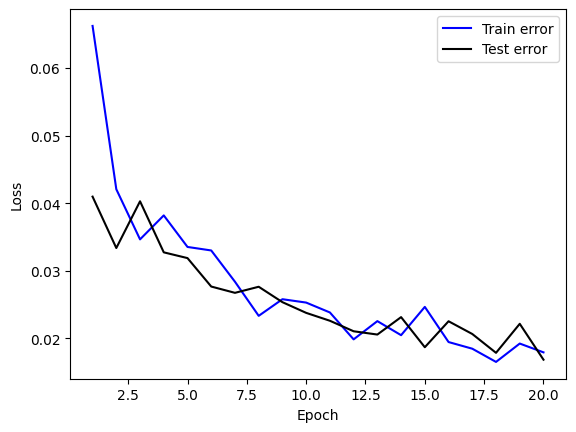

In [28]:
# 학습 곡선 출력(손실)

plt.plot(history[:, 0], history[:, 1], 'b', label='Train error')
plt.plot(history[:, 0], history[:, 3], 'k', label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

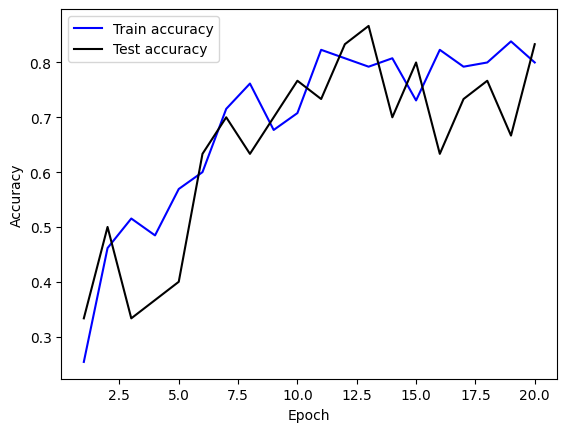

In [29]:
# 학습 곡선 출력 (정확도)

plt.plot(history[:, 0], history[:, 2], 'b', label='Train accuracy')
plt.plot(history[:, 0], history[:, 4], 'k', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()